<a href="https://colab.research.google.com/github/PJMS/p-silmu-2021/blob/main/model/final_heart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 신경망으로 심장마비 예측하기
다양한 컬럼을 가진 심장마비 데이터를 활용하여 심장마비로 사망할 확률을 예측하는 프로젝트입니다.
### 사용 데이터
- kaggle에서 가져옴
https://www.kaggle.com/lirilkumaramal/heart-stroke 
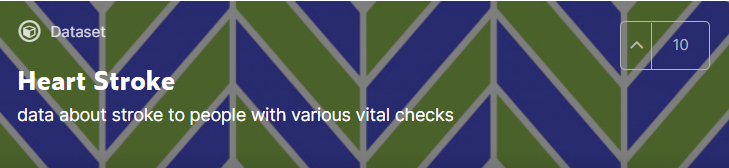
-총 43,400개

## 데이터 분석

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
raw_data = pd.read_csv('/content/drive/MyDrive/heart stroke/train_strokes.csv')
raw_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


- 데이터를 가져오고 각 컬럼을 파악
- 총 12개의 컬럼을 가짐

In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 43400 non-null  int64  
 1   gender             43400 non-null  object 
 2   age                43400 non-null  float64
 3   hypertension       43400 non-null  int64  
 4   heart_disease      43400 non-null  int64  
 5   ever_married       43400 non-null  object 
 6   work_type          43400 non-null  object 
 7   Residence_type     43400 non-null  object 
 8   avg_glucose_level  43400 non-null  float64
 9   bmi                41938 non-null  float64
 10  smoking_status     30108 non-null  object 
 11  stroke             43400 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


- gender, ever_married, work_type, Residence_type, smoking_status에 해당하는 특징의 데이터 타입이 object형
- bmi와 smoking_status는 결측치가 확인됨

In [ ]:
print('성별\n',raw_data['gender'].value_counts(),'\n')
print('결혼 여부\n',raw_data['ever_married'].value_counts(),'\n')
print('일의 종류\n',raw_data['work_type'].value_counts(),'\n')
print('주거 장소\n',raw_data['Residence_type'].value_counts(),'\n')
print('흡연여부\n',raw_data['smoking_status'].value_counts(),'\n')

성별
 Female    25665
Male      17724
Other        11
Name: gender, dtype: int64 

결혼 여부
 Yes    27938
No     15462
Name: ever_married, dtype: int64 

일의 종류
 Private          24834
Self-employed     6793
children          6156
Govt_job          5440
Never_worked       177
Name: work_type, dtype: int64 

주거 장소
 Urban    21756
Rural    21644
Name: Residence_type, dtype: int64 

흡연여부
 never smoked       16053
formerly smoked     7493
smokes              6562
Name: smoking_status, dtype: int64 



- object데이터형의 컬럼에 어떠한 고윳값들이 존재하는지 확인

## 데이터 전처리 

#### id & avg_glucose_level 컬럼 제거

In [ ]:
heart_df = raw_data.drop(['avg_glucose_level','id'],axis=1)

In [ ]:
heart_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,bmi,smoking_status,stroke
0,Male,3.0,0,0,No,children,Rural,18.0,NaN,0
1,Male,58.0,1,0,Yes,Private,Urban,39.2,never smoked,0
2,Female,8.0,0,0,No,Private,Urban,17.6,NaN,0
3,Female,70.0,0,0,Yes,Private,Rural,35.9,formerly smoked,0
4,Male,14.0,0,0,No,Never_worked,Rural,19.1,NaN,0


- id컬럼은 예측에 도움이 되지 않는 부분이라서 제거를 시켰고 글루코스 수치(avg_glucose_level)의 경우에는 개인이 따로 구하기 힘든 특징이라고 생각해 해당 컬럼을 제거 했습니다

#### 성별에서 other에 해당하는 로우 제거

In [ ]:
other_c = heart_df['gender'] == 'Other'
is_other = heart_df[other_c]
is_other

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,bmi,smoking_status,stroke
2914,Other,26.0,0,0,No,Private,Rural,22.4,formerly smoked,0
10768,Other,46.0,0,0,No,Private,Rural,NaN,never smoked,0
15620,Other,27.0,0,0,No,Private,Urban,NaN,smokes,0
15838,Other,53.0,0,0,Yes,Private,Rural,NaN,NaN,0
19748,Other,39.0,0,0,Yes,Govt_job,Urban,32.0,formerly smoked,0
21041,Other,19.0,0,0,No,Private,Rural,32.2,formerly smoked,0
21192,Other,49.0,0,0,Yes,Private,Urban,37.2,never smoked,0
24252,Other,51.0,0,0,Yes,Private,Rural,32.2,formerly smoked,0
26199,Other,10.0,0,0,No,children,Rural,21.2,formerly smoked,0
26831,Other,53.0,0,0,Yes,Govt_job,Urban,NaN,NaN,0


In [ ]:
gender_condition =heart_df[heart_df['gender'] == 'Other'].index
heart_df.drop(gender_condition,inplace=True)

- 성별 중에 other값이라는게 있어서 따로 로우를 설정해 확인해본 결과 그 수가 몇개 안되고 stroke값도 전부 0으로 되어있어 결과 예측에 별 도움이 되지 않을거라고 판단해 해당 로우를 제거하기로함

### 결측치 채우기

In [ ]:
raw_data.isnull().sum()

id                       0
gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

- bmi와 smoking_status 해당하는 결측치를 해결해야함

#### bmi결측치

- bmi의 결측치를 채워넣기 위해 연령&성별 bmi수치를 가져와 각 조건에 맞는 bmi 수치를 입력해줌
https://mangome.tistory.com/245  
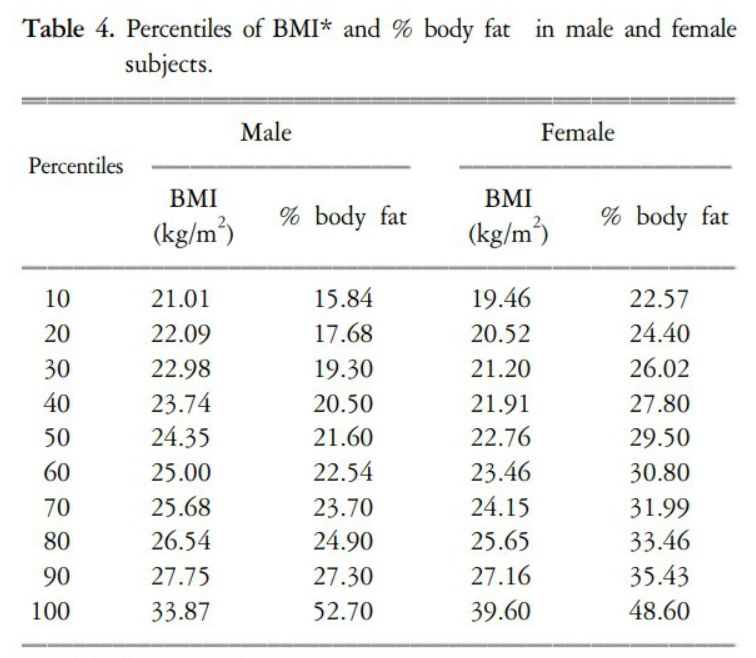

In [ ]:
condition_1_m = (heart_df['gender'] == 'Male') & (heart_df['age'] <10 ) # 각 연령과 성별에 맞는 조건식 설정
condition_1_f = (heart_df['gender'] == 'Female') & (heart_df['age'] <10 )

condition_2_m = (heart_df['gender'] == 'Male') & ((heart_df['age'] >=10) & (heart_df['age'] < 20) )
condition_2_f = (heart_df['gender'] == 'Female') & ((heart_df['age'] >=10) & (heart_df['age'] < 20) )

condition_3_m = (heart_df['gender'] == 'Male') & ((heart_df['age'] >=20) & (heart_df['age'] < 30) )
condition_3_f = (heart_df['gender'] == 'Female') & ((heart_df['age'] >=20) & (heart_df['age'] < 30 ))

condition_4_m = (heart_df['gender'] == 'Male') & ((heart_df['age'] >=30) & (heart_df['age'] < 40) )
condition_4_f = (heart_df['gender'] == 'Female') & ((heart_df['age'] >=30) & (heart_df['age'] < 40) )

condition_5_m = (heart_df['gender'] == 'Male') & ((heart_df['age'] >=40) & (heart_df['age'] < 50) )
condition_5_f = (heart_df['gender'] == 'Female') & ((heart_df['age'] >=40) &( heart_df['age'] < 50 ))

condition_6_m = (heart_df['gender'] == 'Male') & ((heart_df['age'] >=50) & (heart_df['age'] < 60) )
condition_6_f = (heart_df['gender'] == 'Female') & ((heart_df['age'] >=50) & (heart_df['age'] < 60) )

condition_7_m = (heart_df['gender'] == 'Male') & ((heart_df['age'] >=60) & (heart_df['age'] < 70) )
condition_7_f = (heart_df['gender'] == 'Female') & ((heart_df['age'] >=60) & (heart_df['age'] < 70) )

condition_8_m = (heart_df['gender'] == 'Male') & ((heart_df['age'] >=70) & (heart_df['age'] < 80) )
condition_8_f = (heart_df['gender'] == 'Female') & ((heart_df['age'] >=70) & (heart_df['age'] < 80) )

condition_9_m = (heart_df['gender'] == 'Male') & (heart_df['age'] >=80 )
condition_9_f = (heart_df['gender'] == 'Female') & (heart_df['age'] >=80 )

In [ ]:
heart_df.loc[(condition_1_f)&(heart_df.bmi.isna()),'bmi'] = 19.46
heart_df.loc[(condition_1_m)&(heart_df.bmi.isna()),'bmi'] = 21.01

heart_df.loc[(condition_2_f)&(heart_df.bmi.isna()),'bmi'] = 20.52
heart_df.loc[(condition_2_m)&(heart_df.bmi.isna()),'bmi'] = 22.09

heart_df.loc[(condition_3_f)&(heart_df.bmi.isna()),'bmi'] = 21.20
heart_df.loc[(condition_3_m)&(heart_df.bmi.isna()),'bmi'] = 22.98

heart_df.loc[(condition_4_f)&(heart_df.bmi.isna()),'bmi'] = 21.91
heart_df.loc[(condition_4_m)&(heart_df.bmi.isna()),'bmi'] = 23.74

heart_df.loc[(condition_5_f)&(heart_df.bmi.isna()),'bmi'] = 22.76
heart_df.loc[(condition_5_m)&(heart_df.bmi.isna()),'bmi'] = 24.35

heart_df.loc[(condition_6_f)&(heart_df.bmi.isna()),'bmi'] = 23.46
heart_df.loc[(condition_6_m)&(heart_df.bmi.isna()),'bmi'] = 25.00

heart_df.loc[(condition_7_f)&(heart_df.bmi.isna()),'bmi'] = 24.15
heart_df.loc[(condition_7_m)&(heart_df.bmi.isna()),'bmi'] = 25.68

heart_df.loc[(condition_8_f)&(heart_df.bmi.isna()),'bmi'] = 25.65
heart_df.loc[(condition_8_m)&(heart_df.bmi.isna()),'bmi'] = 26.54

heart_df.loc[(condition_9_f)&(heart_df.bmi.isna()),'bmi'] = 27.16
heart_df.loc[(condition_9_m)&(heart_df.bmi.isna()),'bmi'] = 27.75

- bmi수치 테이블을 보고 결측치를 넣어줌

In [ ]:
heart_df.isnull().sum()

gender                0
age                   0
hypertension          0
heart_disease         0
ever_married          0
work_type             0
Residence_type        0
bmi                   0
smoking_status    13290
stroke                0
dtype: int64

#### smoking_status 결측치

In [ ]:
heart_df['smoking_status'].fillna('never smoked',inplace = True)
heart_df.isnull().sum()

gender            0
age               0
hypertension      0
heart_disease     0
ever_married      0
work_type         0
Residence_type    0
bmi               0
smoking_status    0
stroke            0
dtype: int64

- smoking_status는 가장 최빈값인 never smoked값으로 채워줌

## 모델 훈련

In [2]:
data = pd.read_csv('/content/drive/MyDrive/heart stroke/prepro_data_5.csv')
data.head(3)

,Unnamed: 0,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,bmi,smoking_status,stroke
0,0,30669,Male,3.0,0,0,No,children,Rural,18.0,never smoked,0
1,1,30468,Male,58.0,1,0,Yes,Private,Urban,39.2,never smoked,0
2,2,16523,Female,8.0,0,0,No,Private,Urban,17.6,never smoked,0


- 위에서 1차로 전처리된 데이터를 가져옴

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43389 entries, 0 to 43388
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      43389 non-null  int64  
 1   id              43389 non-null  int64  
 2   gender          43389 non-null  object 
 3   age             43389 non-null  float64
 4   hypertension    43389 non-null  int64  
 5   heart_disease   43389 non-null  int64  
 6   ever_married    43389 non-null  object 
 7   work_type       43389 non-null  object 
 8   Residence_type  43389 non-null  object 
 9   smoking_status  43389 non-null  object 
 10  stroke          43389 non-null  int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 3.6+ MB


#### 훈련에 불필요한 컬럼제거
id값과 Unnamed는 예측에 전혀 필요가 없으니 제거 한다

In [3]:
h_data = data.drop(['Unnamed: 0','id'],axis=1)
h_data.head(2)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,bmi,smoking_status,stroke
0,Male,3.0,0,0,No,children,Rural,18.0,never smoked,0
1,Male,58.0,1,0,Yes,Private,Urban,39.2,never smoked,0


### 훈련시킬 데이터와 레이블 값을 분리

In [4]:
data_f = h_data.drop('stroke',axis=1)
data_l = h_data['stroke'] # 0은 정상 1은 심장마비로 사망

### object형 데이터를 정수형 데이터로 변환

In [5]:
gender_mapping = {'Female':0,'Male':1}
married_mapping = {'Yes':0,'No':1}
work_mapping = {'Private':0,'Self-employed':1,'children':2,'Govt_job':3,'Never_worked':4}
Res_mapping = {'Urban':0,'Rural':1}
smoke_mapping ={'never smoked':0,'formerly smoked':1,'smokes':2}

In [6]:
data_f['gender'] = data_f['gender'].map(gender_mapping)
data_f['ever_married'] = data_f['ever_married'].map(married_mapping)
data_f['work_type'] = data_f['work_type'].map(work_mapping)
data_f['Residence_type'] = data_f['Residence_type'].map(Res_mapping)
data_f['smoking_status'] = data_f['smoking_status'].map(smoke_mapping)

- 각각의 값들을 정수로 맵핑 시켜준다

In [7]:
data_f.info() # 정수형으로 바뀐걸 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43389 entries, 0 to 43388
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          43389 non-null  int64  
 1   age             43389 non-null  float64
 2   hypertension    43389 non-null  int64  
 3   heart_disease   43389 non-null  int64  
 4   ever_married    43389 non-null  int64  
 5   work_type       43389 non-null  int64  
 6   Residence_type  43389 non-null  int64  
 7   bmi             43389 non-null  float64
 8   smoking_status  43389 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 3.0 MB


### 훈련을 위한 값 정규화

In [8]:
feature_data = data_f.to_numpy() # 먼저 넘파이로 바꿔줌
label_data = data_l.to_numpy()

In [9]:
def Normalize(input_data): #정규화를 시켜주는 부분
  x_data = input_data.astype('float32')

  mean = x_data.mean(axis=0) # 평균값을 구함
  std =x_data.std(axis=0) #표준편차를 구함

  output_data = input_data.astype('float32') # 실수형으로 변환 뒤 모든 데이터에서 평균을 빼주고 표준편차로 나눔
  output_data -= mean
  output_data /= std

  return output_data

In [10]:
feature_data = Normalize(feature_data)
feature_data.shape

(43389, 9)

### 훈련, 검증 , 테스트 데이터 나누기

In [11]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_lables, test_labels = train_test_split(feature_data, label_data, test_size=0.2, shuffle=True, stratify=label_data, random_state=34)

In [12]:
print('테스트 데이터의 수:',len(test_data))

테스트 데이터의 수: 8678


In [13]:
train_data, valid_data, train_lables, valid_labels = train_test_split(train_data, train_lables, test_size=0.2, shuffle=True, stratify=train_lables, random_state=34)

In [14]:
print("훈련 데이터:",len(train_data))
print("검증 데이터:",len(valid_data))

훈련 데이터: 27768
검증 데이터: 6943


- 레이블 값(심장 마비 여부)을 기준으로 데이터를 훈련,검증,테스트로 나눔

### 간단한 신경망으로 모델 훈련

#### 모델 설계&훈련

In [15]:
from keras import models 
from keras import layers
from keras.layers import Dropout  

model = models.Sequential()
model.add(layers.Dense(32,activation='relu',input_shape=(8,)))
model.add(Dropout(0.2))
model.add(layers.Dense(16,activation='relu'))
model.add(Dropout(0.2))
model.add(layers.Dense(1,activation='sigmoid'))

In [16]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                288       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_1 = model.fit(train_data,
                    train_lables,
                    epochs=10,
                    batch_size=32,
                    validation_data=(valid_data, valid_labels))

Epoch 1/10
868/868 [==============================] - 2s 2ms/step - loss: 0.2057 - accuracy: 0.9292 - val_loss: 0.1022 - val_accuracy: 0.9793
Epoch 2/10
868/868 [==============================] - 2s 2ms/step - loss: 0.1157 - accuracy: 0.9688 - val_loss: 0.0813 - val_accuracy: 0.9831
Epoch 3/10
868/868 [==============================] - 2s 2ms/step - loss: 0.1012 - accuracy: 0.9729 - val_loss: 0.0742 - val_accuracy: 0.9844
Epoch 4/10
868/868 [==============================] - 1s 2ms/step - loss: 0.0947 - accuracy: 0.9755 - val_loss: 0.0706 - val_accuracy: 0.9855
Epoch 5/10
868/868 [==============================] - 2s 2ms/step - loss: 0.0896 - accuracy: 0.9782 - val_loss: 0.0667 - val_accuracy: 0.9862
Epoch 6/10
868/868 [==============================] - 1s 2ms/step - loss: 0.0847 - accuracy: 0.9799 - val_loss: 0.0660 - val_accuracy: 0.9857
Epoch 7/10
868/868 [==============================] - 1s 2ms/step - loss: 0.0825 - accuracy: 0.9806 - val_loss: 0.0673 - val_accuracy: 0.9842
Epoch 

- 테스트 결과 확인

In [ ]:
loss, acc  = model.evaluate(test_data,test_labels)

272/272 [==============================] - 0s 1ms/step - loss: 0.0656 - accuracy: 0.9841
